In [1]:
!nvidia-smi

Tue May  5 12:48:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!mkdir .kaggle

In [0]:
# 导入 API Token，token 为上述 kaggle.json 文件内容，创建一个 kaggle.json 文件
import json
token = {"username":"qhaoguo","key":"bf88c68cc306ec951f78f9f3a23f7246"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
# 让 kaggle.json 赋予更高的权限
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
# 复制到系统目录
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
# 设置下载的文件夹路径
!kaggle config set -n path -v /content

- path is now set to: /content


In [7]:
# 粘贴命令并顺便指明存储路径
!kaggle competitions download -c dogs-vs-cats -p /content

 97% 529M/543M [00:04<00:00, 112MB/s]
100% 543M/543M [00:04<00:00, 117MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 77.8MB/s]
 99% 268M/271M [00:03<00:00, 131MB/s]
100% 271M/271M [00:03<00:00, 92.4MB/s]


In [8]:
!unzip train.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.

In [9]:
!unzip test1.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           
  inflating: test1/5520.jpg          
  inflating: test1/5521

In [10]:
!wget https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz

--2020-05-05 12:49:16--  https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553436134 (528M)
Saving to: ‘vgg16_weights.npz’

vgg16_weights.npz   100%[===================>] 527.80M  49.1MB/s    in 11s     

2020-05-05 12:49:27 (48.0 MB/s) - ‘vgg16_weights.npz’ saved [553436134/553436134]



In [0]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.2.0-rc3'

In [0]:
learning_rate = 0.0001
BATCH_SIZE = 50
training_steps = 1000
display_step = 20
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3

In [0]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [0]:
random_normal = tf.initializers.RandomNormal()

parameters = {
    'conv1_1_W': tf.Variable(random_normal([3, 3, 3, 64]), trainable=False),
    'conv1_1_b': tf.Variable(tf.zeros([64]), trainable=False),
    'conv1_2_W': tf.Variable(random_normal([3, 3, 64, 64]), trainable=False),
    'conv1_2_b': tf.Variable(tf.zeros([64]), trainable=False),

    'conv2_1_W': tf.Variable(random_normal([3, 3, 64, 128]), trainable=False),
    'conv2_1_b': tf.Variable(tf.zeros([128]), trainable=False),
    'conv2_2_W': tf.Variable(random_normal([3, 3, 128, 128]), trainable=False),
    'conv2_2_b': tf.Variable(tf.zeros([128]), trainable=False),

    'conv3_1_W': tf.Variable(random_normal([3, 3, 128, 256]), trainable=False),
    'conv3_1_b': tf.Variable(tf.zeros([256]), trainable=False),
    'conv3_2_W': tf.Variable(random_normal([3, 3, 256, 256]), trainable=False),
    'conv3_2_b': tf.Variable(tf.zeros([256]), trainable=False),
    'conv3_3_W': tf.Variable(random_normal([3, 3, 256, 256]), trainable=False),
    'conv3_3_b': tf.Variable(tf.zeros([256]), trainable=False),

    'conv4_1_W': tf.Variable(random_normal([3, 3, 256, 512]), trainable=False),
    'conv4_1_b': tf.Variable(tf.zeros([512]), trainable=False),
    'conv4_2_W': tf.Variable(random_normal([3, 3, 512, 512]), trainable=False),
    'conv4_2_b': tf.Variable(tf.zeros([512]), trainable=False),
    'conv4_3_W': tf.Variable(random_normal([3, 3, 512, 512]), trainable=False),
    'conv4_3_b': tf.Variable(tf.zeros([512]), trainable=False),

    'conv5_1_W': tf.Variable(random_normal([3, 3, 512, 512]), trainable=False),
    'conv5_1_b': tf.Variable(tf.zeros([512]), trainable=False),
    'conv5_2_W': tf.Variable(random_normal([3, 3, 512, 512]), trainable=False),
    'conv5_2_b': tf.Variable(tf.zeros([512]), trainable=False),
    'conv5_3_W': tf.Variable(random_normal([3, 3, 512, 512]), trainable=False),
    'conv5_3_b': tf.Variable(tf.zeros([512]), trainable=False),

    'fc6_W': tf.Variable(random_normal([25088, 4096]), trainable=False),
    'fc6_b': tf.Variable(tf.zeros([4096]), trainable=False),

    'fc7_W': tf.Variable(random_normal([4096, 4096]), trainable=False),
    'fc7_b': tf.Variable(tf.zeros([4096]), trainable=False),

    'fc8_W': tf.Variable(random_normal([4096, 2]), trainable=True),
    'fc8_b': tf.Variable(tf.zeros([2]), trainable=True)
}

In [0]:
weights = np.load('./vgg16_weights.npz')
keys = sorted(weights.keys())
for i, k in enumerate(keys):
    if i not in [30, 31]:
        parameters[k] = tf.cast(weights[k], tf.float32)

In [0]:
def conv_net(x):
    x = tf.reshape(x, [-1, 224, 224, 3])
    conv1_1 = conv2d(x, parameters['conv1_1_W'], parameters['conv1_1_b'])
    conv1_2 = conv2d(conv1_1, parameters['conv1_2_W'], parameters['conv1_2_b'])
    pool1 = maxpool2d(conv1_2, k=2)

    conv2_1 = conv2d(pool1, parameters['conv2_1_W'], parameters['conv2_1_b'])
    conv2_2 = conv2d(conv2_1, parameters['conv2_2_W'], parameters['conv2_2_b'])
    pool2 = maxpool2d(conv2_2, k=2)

    conv3_1 = conv2d(pool2, parameters['conv3_1_W'], parameters['conv3_1_b'])
    conv3_2 = conv2d(conv3_1, parameters['conv3_2_W'], parameters['conv3_2_b'])
    conv3_3 = conv2d(conv3_2, parameters['conv3_3_W'], parameters['conv3_3_b'])
    pool3 = maxpool2d(conv3_3, k=2)

    conv4_1 = conv2d(pool3, parameters['conv4_1_W'], parameters['conv4_1_b'])
    conv4_2 = conv2d(conv4_1, parameters['conv4_2_W'], parameters['conv4_2_b'])
    conv4_3 = conv2d(conv4_2, parameters['conv4_3_W'], parameters['conv4_3_b'])
    pool4 = maxpool2d(conv4_3, k=2)

    conv5_1 = conv2d(pool4, parameters['conv5_1_W'], parameters['conv5_1_b'])
    conv5_2 = conv2d(conv5_1, parameters['conv5_2_W'], parameters['conv5_2_b'])
    conv5_3 = conv2d(conv5_2, parameters['conv5_3_W'], parameters['conv5_3_b'])
    pool5 = maxpool2d(conv5_3, k=2)

    flat = tf.reshape(pool5, [-1, parameters['fc6_W'].shape[0]])
    fc6 = tf.add(tf.matmul(flat, parameters['fc6_W']), parameters['fc6_b'])
    fc6 = tf.nn.relu(fc6)

    fc7 = tf.add(tf.matmul(fc6, parameters['fc7_W']), parameters['fc7_b'])
    fc7 = tf.nn.relu(fc7)

    out = tf.add(tf.matmul(fc7, parameters['fc8_W']), parameters['fc8_b'])

    return tf.nn.softmax(out)

In [0]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=NUM_CHANNELS)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image /= 255.0

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def get_file(file_dir):
    labels = []
    images = []
    for root, _, files in os.walk(file_dir):
        for name in files:
            cls_name = name.split('.')[0]
            if cls_name == 'cat':
                labels.append(0)
                images.append(file_dir + name)
            else:
                labels.append(1)
                images.append(file_dir + name)

    temp = np.array([images, labels])
    temp = temp.transpose()
    np.random.shuffle(temp)
    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(float(i)) for i in label_list]
    
    return image_list, label_list

In [0]:
file_dir = 'train/'
files, categories = get_file(file_dir)

path_dataset = tf.data.Dataset.from_tensor_slices(files)
image_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(categories, tf.int64))
image_label_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

dataset = image_label_dataset.repeat().shuffle(1000).batch(BATCH_SIZE).prefetch(1)

In [0]:
def cross_entropy(y_pred, y_true):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true=y_true, y_pred=y_pred)
    
    return tf.reduce_mean(loss_)


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.reshape(tf.cast(y_true, tf.int64), [-1]))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.Adam(learning_rate)

In [0]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    trainable_variables = [list(parameters.values())[-1], list(parameters.values())[-2]]
    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [75]:
train_loss_list = []
train_acc_list = []

for step, (batch_x, batch_y) in enumerate(dataset.take(training_steps), 1):
    run_optimization(batch_x, batch_y)

    pred = conv_net(batch_x)
    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    train_loss_list.append(loss.numpy())
    train_acc_list.append(acc.numpy())
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 20, loss: 0.721006, accuracy: 0.560000
step: 40, loss: 0.677646, accuracy: 0.540000
step: 60, loss: 0.575373, accuracy: 0.660000
step: 80, loss: 0.606931, accuracy: 0.700000
step: 100, loss: 0.598348, accuracy: 0.680000
step: 120, loss: 0.533174, accuracy: 0.740000
step: 140, loss: 0.493199, accuracy: 0.860000
step: 160, loss: 0.452174, accuracy: 0.780000
step: 180, loss: 0.480984, accuracy: 0.840000
step: 200, loss: 0.454276, accuracy: 0.880000
step: 220, loss: 0.422695, accuracy: 0.860000
step: 240, loss: 0.460156, accuracy: 0.820000
step: 260, loss: 0.480113, accuracy: 0.800000
step: 280, loss: 0.481676, accuracy: 0.720000
step: 300, loss: 0.494331, accuracy: 0.740000
step: 320, loss: 0.384546, accuracy: 0.820000
step: 340, loss: 0.354487, accuracy: 0.900000
step: 360, loss: 0.407718, accuracy: 0.860000
step: 380, loss: 0.484585, accuracy: 0.780000
step: 400, loss: 0.449346, accuracy: 0.840000
step: 420, loss: 0.369119, accuracy: 0.800000
step: 440, loss: 0.448955, accuracy: 0

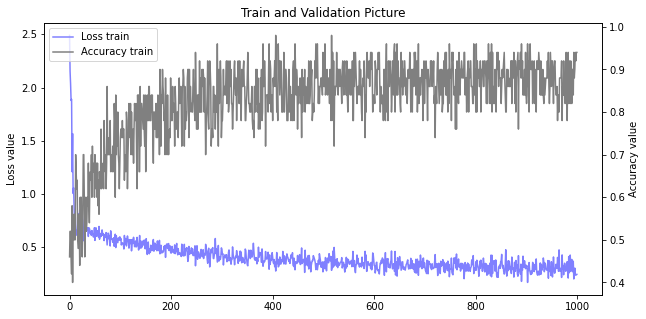

In [76]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line2, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
plt.legend(handles=(line1, line2), loc='best')
plt.show()

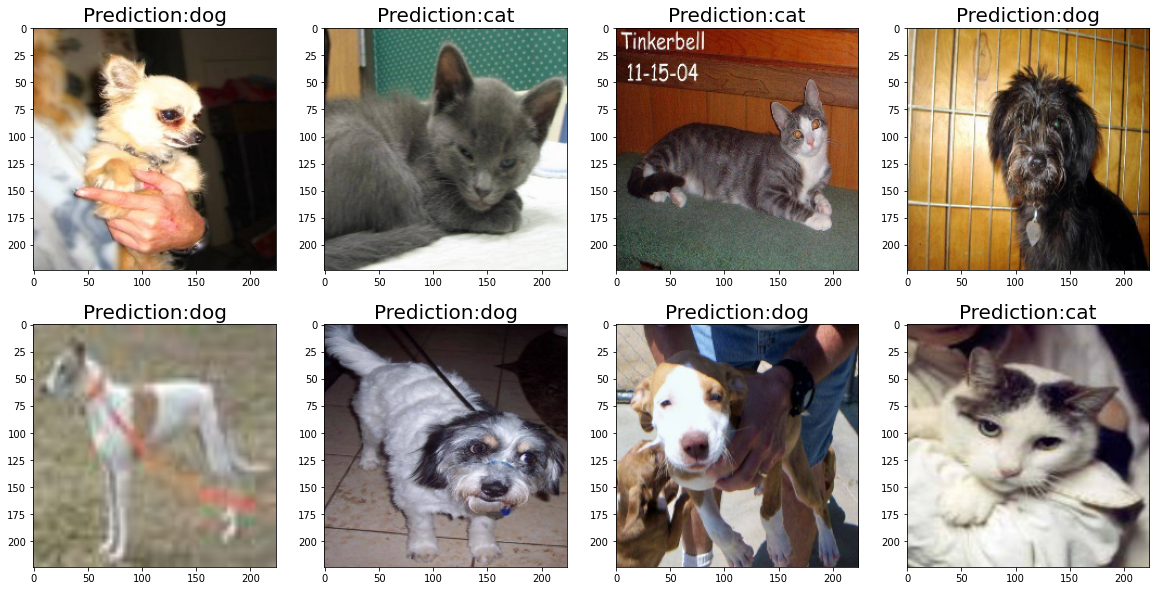

In [77]:
file_i = np.random.randint(12500, size=(1, 8))
filepath = []
plt_images = []
pre_images = []
root_dir = 'test1/'
for i in range(file_i.shape[1]):
    filepath.append(root_dir + str(file_i[0][i]) + '.jpg')
    
for path in filepath:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    IMG = img.copy()
    plt_images.append(IMG)
    del IMG
    pre_images.append(img)

image_batch = np.array(pre_images)
pred = conv_net(image_batch)
max_index = np.argmax(pred, 1)

fig = plt.gcf()
fig.set_size_inches(20, 10)
for i in range(8):
    if max_index[i] == 0:
        cls_name = 'cat'
    else:
        cls_name = 'dog'
    ax = plt.subplot(2, 4, 1 + i)
    ax.imshow(plt_images[i].astype('uint8'), cmap='binary')
    title = 'Prediction:' + cls_name
    ax.set_title(title, fontsize=20)
plt.show()

In [0]:
np.savez('cats_vs_dogs.npz', conv1_1_W=parameters['conv1_1_W'], conv1_1_b=parameters['conv1_1_b'],conv1_2_W=parameters['conv1_2_W'], conv1_2_b=parameters['conv1_2_b'],
         conv2_1_W=parameters['conv2_1_W'], conv2_1_b=parameters['conv2_1_b'], conv2_2_W=parameters['conv2_2_W'], conv2_2_b=parameters['conv2_2_b'],
         conv3_1_W=parameters['conv3_1_W'], conv3_1_b=parameters['conv3_1_b'], conv3_2_W=parameters['conv3_2_W'], conv3_2_b=parameters['conv3_2_b'],
         conv3_3_W=parameters['conv3_3_W'], conv3_3_b=parameters['conv3_3_b'], conv4_1_W=parameters['conv4_1_W'], conv4_1_b=parameters['conv4_1_b'],
         conv4_2_W=parameters['conv4_2_W'], conv4_2_b=parameters['conv4_2_b'], conv4_3_W=parameters['conv4_3_W'], conv4_3_b=parameters['conv4_3_b'],
         conv5_1_W=parameters['conv5_1_W'], conv5_1_b=parameters['conv5_1_b'], conv5_2_W=parameters['conv5_2_W'], conv5_2_b=parameters['conv5_2_b'],
         conv5_3_W=parameters['conv5_3_W'], conv5_3_b=parameters['conv5_3_b'], fc6_W=parameters['fc6_W'], fc6_b=parameters['fc6_b'],
         fc7_W=parameters['fc7_W'], fc7_b=parameters['fc7_b'], fc8_W=parameters['fc8_W'], fc8_b=parameters['fc8_b'],)

In [0]:
weights = np.load('./cats_vs_dogs.npz')
keys = sorted(weights.keys())
for i, k in enumerate(keys):
    if i not in [30, 31]:
        parameters[k] = tf.cast(weights[k], tf.float32)

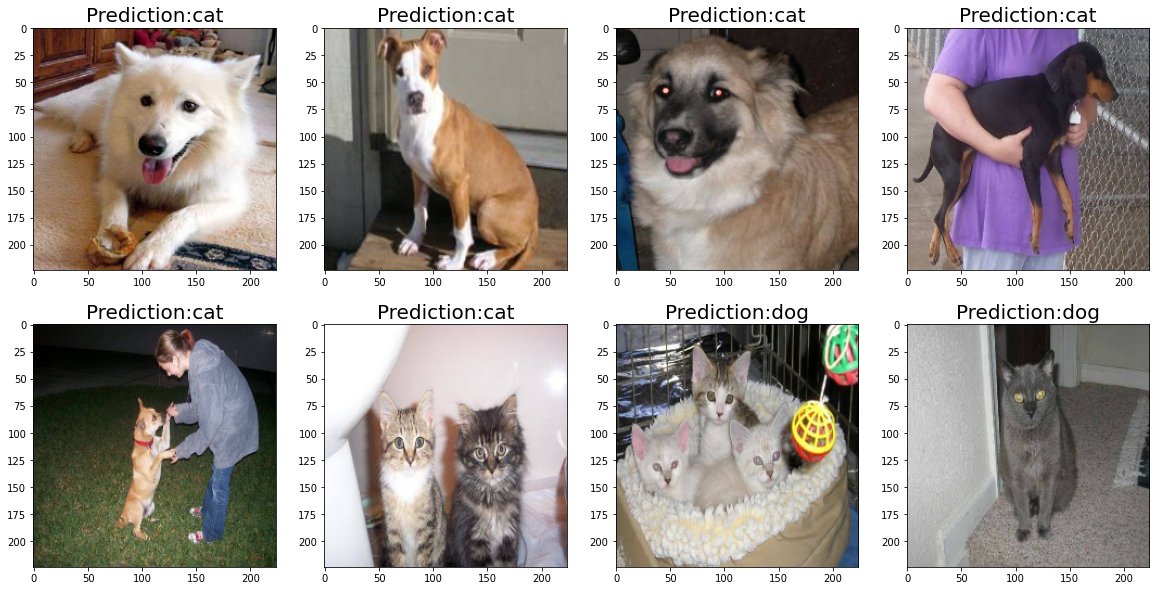

In [8]:
file_i = np.random.randint(12500, size=(1, 8))
filepath = []
plt_images = []
pre_images = []
root_dir = 'test1/'
for i in range(file_i.shape[1]):
    filepath.append(root_dir + str(file_i[0][i]) + '.jpg')
    
for path in filepath:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    IMG = img.copy()
    plt_images.append(IMG)
    del IMG
    pre_images.append(img)

image_batch = np.array(pre_images)
pred = conv_net(image_batch)
max_index = np.argmax(pred, 1)

fig = plt.gcf()
fig.set_size_inches(20, 10)
for i in range(8):
    if max_index[i] == 0:
        cls_name = 'cat'
    else:
        cls_name = 'dog'
    ax = plt.subplot(2, 4, 1 + i)
    ax.imshow(plt_images[i].astype('uint8'), cmap='binary')
    title = 'Prediction:' + cls_name
    ax.set_title(title, fontsize=20)
plt.show()